# Game Outcome Prediction - Round

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from datetime import datetime
import time


from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


### Loading Dataset

In [2]:
master_demos_data = pd.read_csv('mm_master_demos.csv')

In [3]:
master_demos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955466 entries, 0 to 955465
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       955466 non-null  int64  
 1   file             955466 non-null  object 
 2   map              955466 non-null  object 
 3   date             955466 non-null  object 
 4   round            955466 non-null  int64  
 5   tick             955466 non-null  int64  
 6   seconds          955466 non-null  float64
 7   att_team         955466 non-null  object 
 8   vic_team         955466 non-null  object 
 9   att_side         955466 non-null  object 
 10  vic_side         955466 non-null  object 
 11  hp_dmg           955466 non-null  int64  
 12  arm_dmg          955466 non-null  int64  
 13  is_bomb_planted  955466 non-null  bool   
 14  bomb_site        151039 non-null  object 
 15  hitbox           955466 non-null  object 
 16  wp               955466 non-null  obje

### Cleaning the dataset

In [4]:
master_demos_data.isnull().sum()

Unnamed: 0              0
file                    0
map                     0
date                    0
round                   0
tick                    0
seconds                 0
att_team                0
vic_team                0
att_side                0
vic_side                0
hp_dmg                  0
arm_dmg                 0
is_bomb_planted         0
bomb_site          804427
hitbox                  0
wp                      0
wp_type                 0
award                   0
winner_team             0
winner_side             0
att_id                  0
att_rank                0
vic_id                  0
vic_rank                0
att_pos_x               0
att_pos_y               0
vic_pos_x               0
vic_pos_y               0
round_type              0
ct_eq_val               0
t_eq_val                0
avg_match_rank          0
dtype: int64

In [5]:
# Dropping the 'bomb_site' column due to significant missing values
master_demos = master_demos_data.drop(columns=['bomb_site', 'Unnamed: 0'])

# Converting 'date' column to datetime format
master_demos['date'] = pd.to_datetime(master_demos['date'])

# Dropping other columns that might not be necessary for the analysis
# exact positions and player IDs may not be directly relevant for predicting the winning side
columns_to_drop = ['att_id', 'vic_id', 'att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y']
master_demos = master_demos.drop(columns=columns_to_drop)

In [6]:
gc.collect()

0

In [7]:
# Feature Engineering: Creating aggregated metrics per round
# total damage per round, total number of kills per round.
# These will be calculated and added to the dataset
round_aggregates = master_demos.groupby(['file', 'round']).agg(
    total_hp_dmg=('hp_dmg', 'sum'),
    total_arm_dmg=('arm_dmg', 'sum'),
    total_kills=('round', 'size')  # Each row in the dataset represents a kill event
).reset_index()

In [8]:
# Merging the aggregated data back to the main dataset
master_demos = pd.merge(master_demos, round_aggregates, on=['file', 'round'])

master_demos.head()

,file,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,...,winner_side,att_rank,vic_rank,round_type,ct_eq_val,t_eq_val,avg_match_rank,total_hp_dmg,total_arm_dmg,total_kills
0,003201673717864202280_0171883906.dem,de_dust2,2017-09-28 20:44:22,1,8482,133.0582,Team 1,Team 2,CounterTerrorist,Terrorist,...,CounterTerrorist,17,17,PISTOL_ROUND,2950,3850,16.0,800,108,28
1,003201673717864202280_0171883906.dem,de_dust2,2017-09-28 20:44:22,1,8600,134.9023,Team 1,Team 2,CounterTerrorist,Terrorist,...,CounterTerrorist,16,17,PISTOL_ROUND,2950,3850,16.0,800,108,28
2,003201673717864202280_0171883906.dem,de_dust2,2017-09-28 20:44:22,1,8610,135.0586,Team 2,Team 1,Terrorist,CounterTerrorist,...,CounterTerrorist,17,16,PISTOL_ROUND,2950,3850,16.0,800,108,28
3,003201673717864202280_0171883906.dem,de_dust2,2017-09-28 20:44:22,1,8624,135.2774,Team 1,Team 2,CounterTerrorist,Terrorist,...,CounterTerrorist,16,17,PISTOL_ROUND,2950,3850,16.0,800,108,28
4,003201673717864202280_0171883906.dem,de_dust2,2017-09-28 20:44:22,1,8632,135.4024,Team 2,Team 1,Terrorist,CounterTerrorist,...,CounterTerrorist,17,16,PISTOL_ROUND,2950,3850,16.0,800,108,28


In [9]:
master_demos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955466 entries, 0 to 955465
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   file             955466 non-null  object        
 1   map              955466 non-null  object        
 2   date             955466 non-null  datetime64[ns]
 3   round            955466 non-null  int64         
 4   tick             955466 non-null  int64         
 5   seconds          955466 non-null  float64       
 6   att_team         955466 non-null  object        
 7   vic_team         955466 non-null  object        
 8   att_side         955466 non-null  object        
 9   vic_side         955466 non-null  object        
 10  hp_dmg           955466 non-null  int64         
 11  arm_dmg          955466 non-null  int64         
 12  is_bomb_planted  955466 non-null  bool          
 13  hitbox           955466 non-null  object        
 14  wp               955

# EXPLORATORY DATA ANALYSIS

### Distribution of the Target Variable 'winner_side'

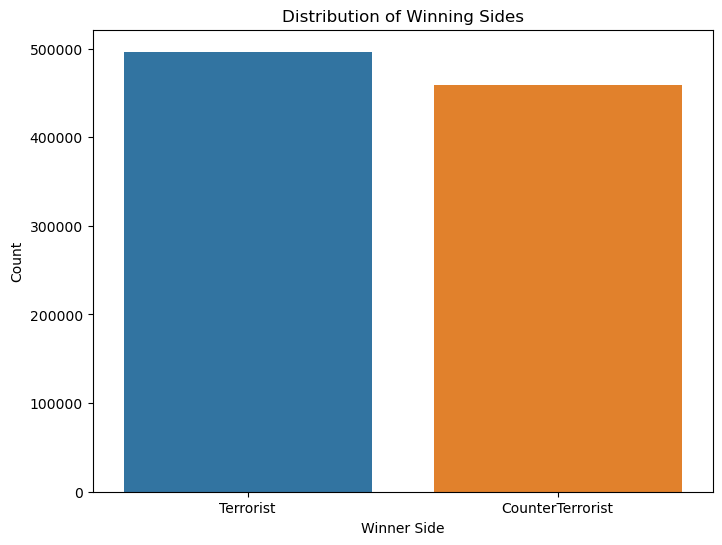

In [10]:
# Distribution of the Target Variable 'winner_side'
winner_side_distribution = master_demos['winner_side'].value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=winner_side_distribution.index, y=winner_side_distribution.values)
plt.title('Distribution of Winning Sides')
plt.xlabel('Winner Side')
plt.ylabel('Count')
plt.show()

### Analyzing the distributions of individual features: 
- 'total_hp_dmg', 
- 'total_arm_dmg', 
- 'total_kills', 
- 'ct_eq_val', 
- 't_eq_val'

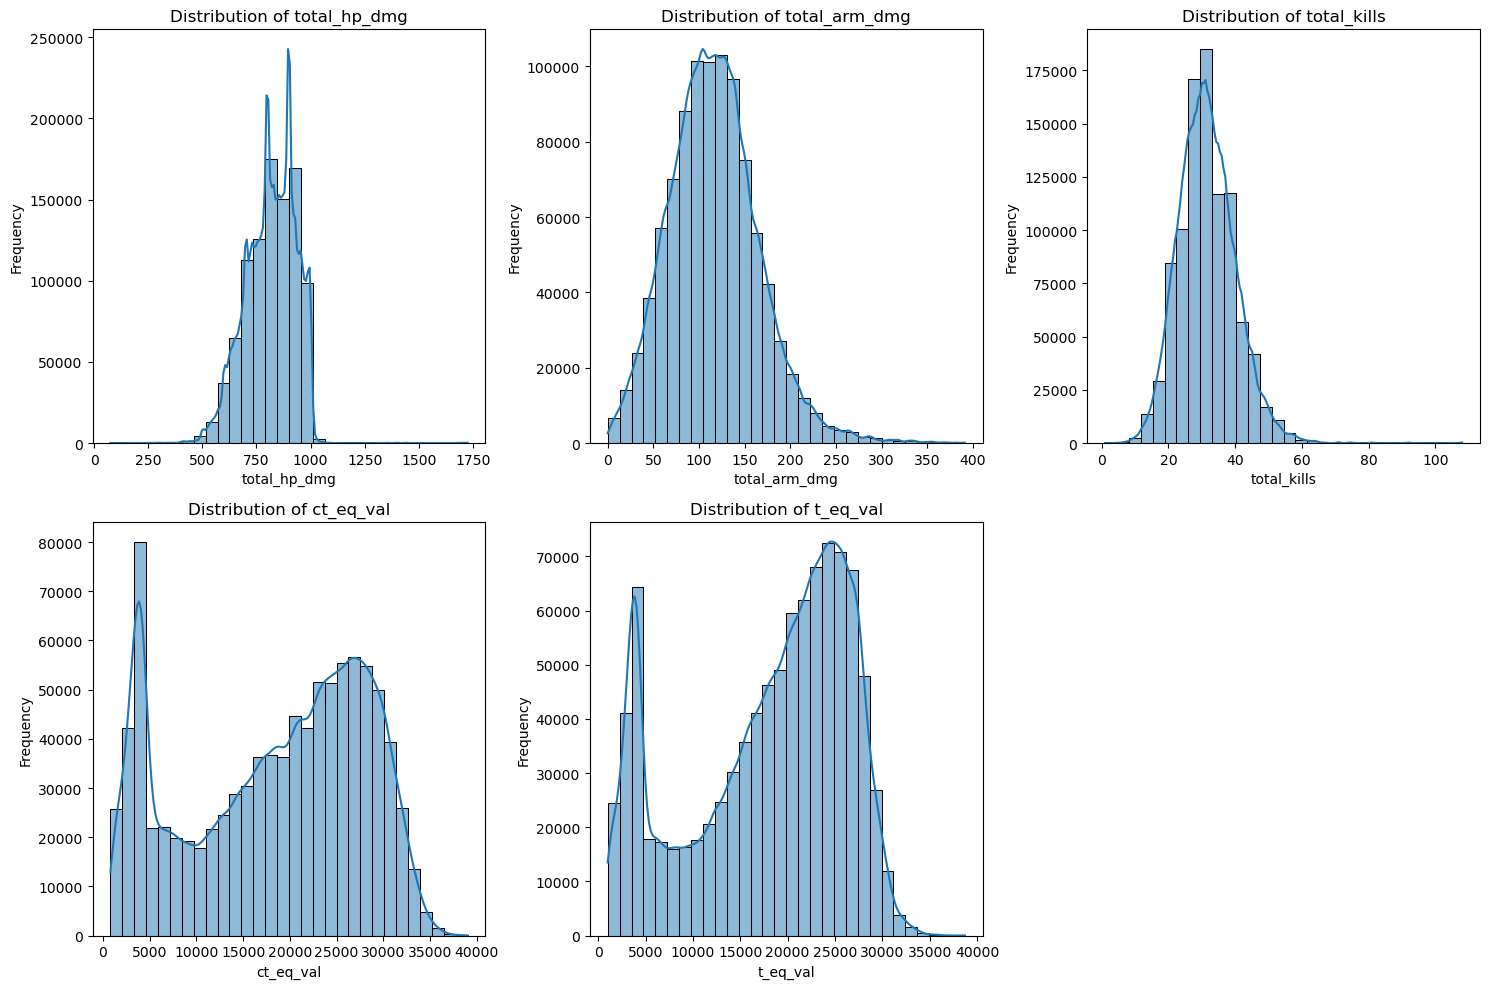

In [11]:

# Selecting the features for distribution analysis
features_for_distribution = ['total_hp_dmg', 'total_arm_dmg', 'total_kills', 'ct_eq_val', 't_eq_val']

# Plotting distributions of these features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the array for easy iteration

for i, col in enumerate(features_for_distribution):
    sns.histplot(master_demos[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Removing the extra subplot (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

### Correlation Analysis

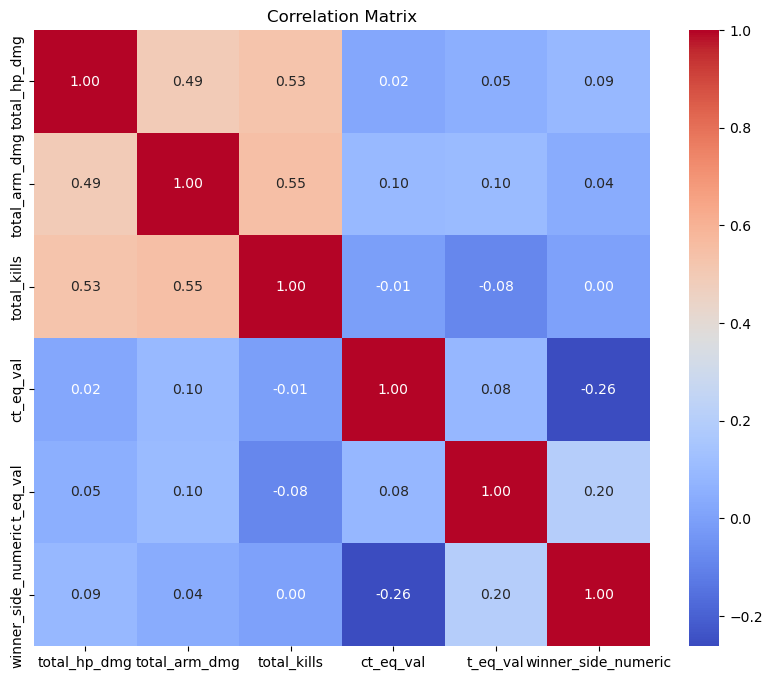

In [12]:
# For correlation analysis, 
# we need to convert the 'winner_side' column to a numeric

# Assigning CounterTerrorist = 0, Terrorist = 1
master_demos['winner_side_numeric'] = master_demos['winner_side'].map({'CounterTerrorist': 0, 'Terrorist': 1})

# Selecting features for correlation analysis
features_for_corr = ['total_hp_dmg', 
                            'total_arm_dmg', 
                            'total_kills', 
                            'ct_eq_val', 
                            't_eq_val', 
                            'winner_side_numeric'
                           ]

# Calculating the correlation matrix
correlation_matrix = master_demos[features_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

### Comparitive Analysis

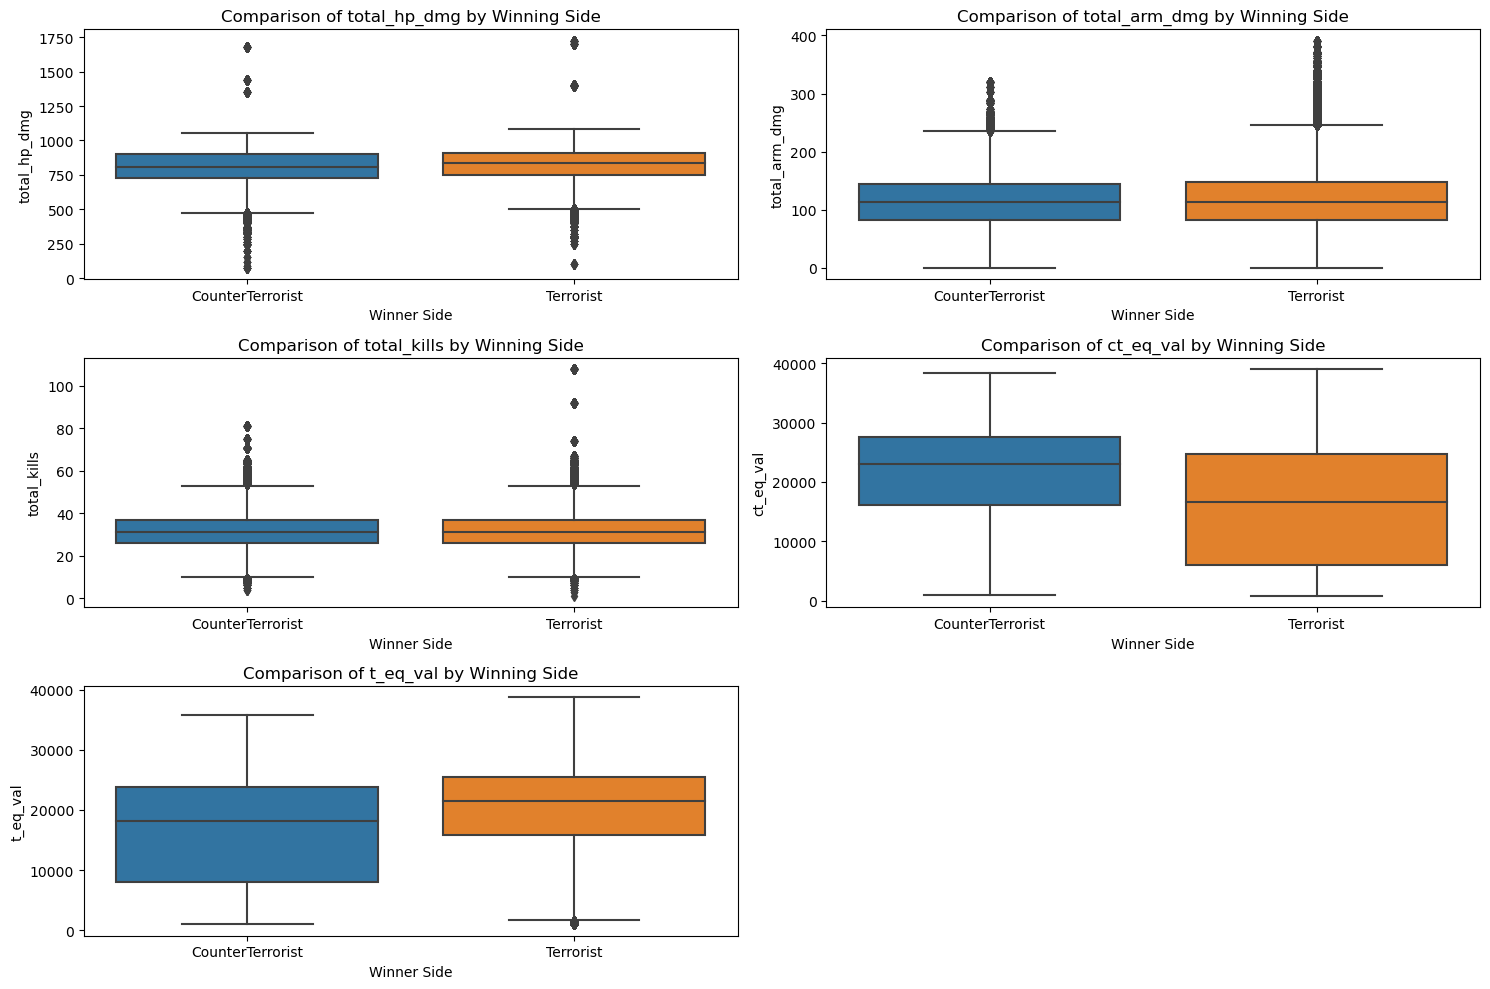

In [13]:
# Comparing features across winning and losing sides

# Features for comparison
comparison_features = ['total_hp_dmg', 'total_arm_dmg', 'total_kills', 'ct_eq_val', 't_eq_val']

# Define the number of rows and columns for subplots
num_rows = (len(comparison_features) + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plotting comparative analysis
for i, feature in enumerate(comparison_features):
    sns.boxplot(x='winner_side', y=feature, data=master_demos, ax=axes[i])
    axes[i].set_title(f'Comparison of {feature} by Winning Side')
    axes[i].set_xlabel('Winner Side')
    axes[i].set_ylabel(feature)

# Remove empty subplots if there are an odd number of features
if len(comparison_features) % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout and display the plots
fig.tight_layout()
plt.show()

In [14]:
"""
# Comparing features across winning and losing sides

# Features for comparison

comparison_features = ['total_hp_dmg', 'total_arm_dmg', 'total_kills', 'ct_eq_val', 't_eq_val']

# Plotting comparative analysis

fig, axes = plt.subplots(nrows=len(comparison_features), ncols=1, figsize=(10, 20))

for i, feature in enumerate(comparison_features):
    sns.boxplot(x='winner_side', y=feature, data=master_demos, ax=axes[i])
    axes[i].set_title(f'Comparison of {feature} by Winning Side')
    axes[i].set_xlabel('Winner Side')
    axes[i].set_ylabel(feature)

fig.tight_layout()
plt.show()


# Identifying outliers in the key features

# Plotting boxplots for outlier detection in the same features
fig, axes = plt.subplots(nrows=len(comparison_features), ncols=1, figsize=(10, 20))

for i, feature in enumerate(comparison_features):
    sns.boxplot(master_demos[feature], ax=axes[i])
    axes[i].set_title(f'Outliers in {feature}')
    axes[i].set_xlabel(feature)

fig.tight_layout()
plt.show()
"""

"\n# Comparing features across winning and losing sides\n\n# Features for comparison\n\ncomparison_features = ['total_hp_dmg', 'total_arm_dmg', 'total_kills', 'ct_eq_val', 't_eq_val']\n\n# Plotting comparative analysis\n\nfig, axes = plt.subplots(nrows=len(comparison_features), ncols=1, figsize=(10, 20))\n\nfor i, feature in enumerate(comparison_features):\n    sns.boxplot(x='winner_side', y=feature, data=master_demos, ax=axes[i])\n    axes[i].set_title(f'Comparison of {feature} by Winning Side')\n    axes[i].set_xlabel('Winner Side')\n    axes[i].set_ylabel(feature)\n\nfig.tight_layout()\nplt.show()\n\n\n# Identifying outliers in the key features\n\n# Plotting boxplots for outlier detection in the same features\nfig, axes = plt.subplots(nrows=len(comparison_features), ncols=1, figsize=(10, 20))\n\nfor i, feature in enumerate(comparison_features):\n    sns.boxplot(master_demos[feature], ax=axes[i])\n    axes[i].set_title(f'Outliers in {feature}')\n    axes[i].set_xlabel(feature)\n\nfig

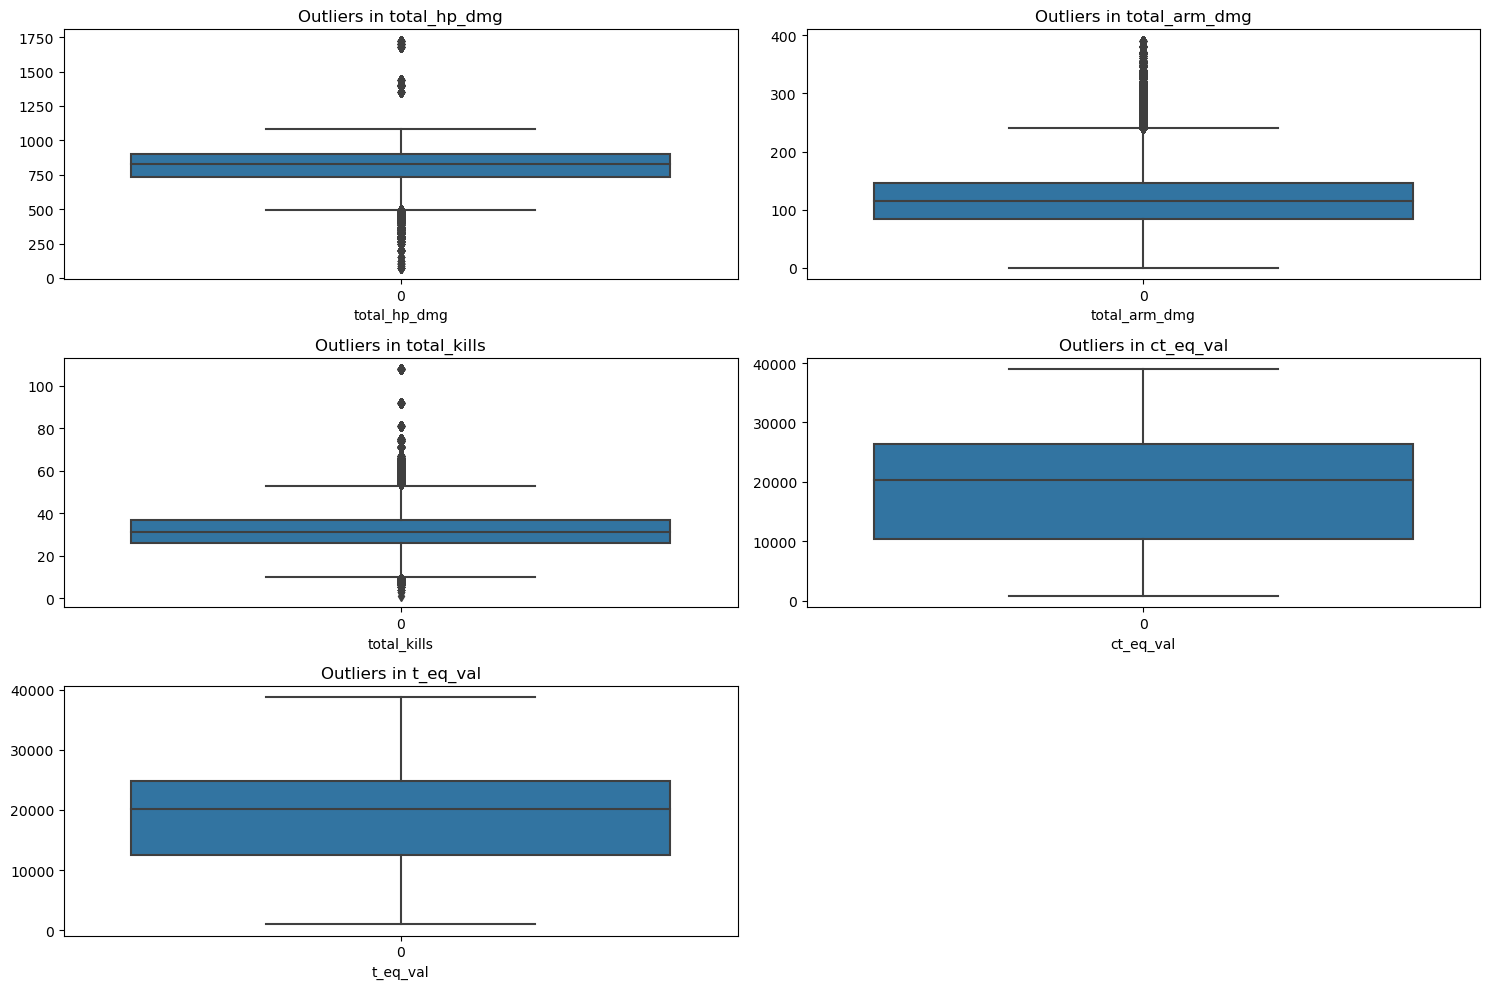

In [15]:
# Features for outlier detection
outlier_features = ['total_hp_dmg', 'total_arm_dmg', 'total_kills', 'ct_eq_val', 't_eq_val']

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plotting boxplots for outlier detection
for i, feature in enumerate(outlier_features):
    sns.boxplot(master_demos[feature], ax=axes[i])
    axes[i].set_title(f'Outliers in {feature}')
    axes[i].set_xlabel(feature)

# Remove empty subplots if there are an odd number of features
if len(outlier_features) % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout and display the plots
fig.tight_layout()
plt.show()

# PREPROCESSING

In [16]:
master_demos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955466 entries, 0 to 955465
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   file                 955466 non-null  object        
 1   map                  955466 non-null  object        
 2   date                 955466 non-null  datetime64[ns]
 3   round                955466 non-null  int64         
 4   tick                 955466 non-null  int64         
 5   seconds              955466 non-null  float64       
 6   att_team             955466 non-null  object        
 7   vic_team             955466 non-null  object        
 8   att_side             955466 non-null  object        
 9   vic_side             955466 non-null  object        
 10  hp_dmg               955466 non-null  int64         
 11  arm_dmg              955466 non-null  int64         
 12  is_bomb_planted      955466 non-null  bool          
 13  hitbox        

### Encoding Categorical Features and  Handling Outliers

In [17]:
# One-hot encoding
categorical_features = ['map', 
                        'round_type'
                       ]

# Handling outliers with log transformation
skewed_features = ['total_hp_dmg', 
                   'total_arm_dmg', 
                   'ct_eq_val', 
                   't_eq_val'
                  ]
master_demos[skewed_features] = master_demos[skewed_features].apply(lambda x: np.log(x + 1))

# One-hot encoding categorical variables
one_hot_encoder = OneHotEncoder()
encoded_categorical = one_hot_encoder.fit_transform(master_demos[categorical_features]).toarray()
encoded_categorical_df = pd.DataFrame(encoded_categorical, 
                                      columns=one_hot_encoder.get_feature_names_out(categorical_features)
                                     )

In [18]:
# Combining encoded categorical features with the rest of the dataset
master_demos = master_demos.drop(columns=categorical_features)
master_demos = pd.concat([master_demos, encoded_categorical_df], axis=1)

# Selecting only numeric features for scaling
numeric_features = master_demos.select_dtypes(include=['float64', 'int64', 'uint8']).columns.tolist()
numeric_features.remove('winner_side_numeric')  # Removing the target variable

### Normalizing the data

In [19]:
# Scaling the numeric features
scaler = StandardScaler()
master_demos[numeric_features] = scaler.fit_transform(master_demos[numeric_features])

### Partitioning the Dataset 70 - 30 split

In [20]:
# Separating features (X) and target variable (y)
X = master_demos[numeric_features]
y = master_demos['winner_side_numeric']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Confirming the preprocessing steps
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668826, 40), (286640, 40), (668826,), (286640,))

# MODEL SELECTION

In [21]:
# list of machine learning models
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('xGBoost', XGBClassifier())
]

# Iterate through the models and perform training and evaluation
for name, model in models:
    start_time = time.time()
    # Fit the model on the training set
    model.fit(X_train, y_train)
    end_time = time.time()
    
    # Calculate the time taken by the model
    elapsed_time = end_time - start_time

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model using various metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    # Print the evaluation results for each model
    print(f"Model: {name}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"AUC-ROC Score: {auc_roc}")
    print(f"Time taken: {elapsed_time} seconds")
    print("------------------------------------------")

Model: Logistic Regression
Test Accuracy: 0.6495883337984929
Precision: 0.659560702189887
Recall: 0.6714858951868207
F1-Score: 0.6654698782339932
AUC-ROC Score: 0.6487212373200191
Time taken: 1.4625232219696045 seconds
------------------------------------------
Model: Decision Tree
Test Accuracy: 0.9989080379570192
Precision: 0.9989447506385267
Recall: 0.9989514649244853
F1-Score: 0.9989481077702238
AUC-ROC Score: 0.9989063183422232
Time taken: 6.043388843536377 seconds
------------------------------------------
Model: Random Forest
Test Accuracy: 0.9993092380686576
Precision: 0.9990125944584383
Recall: 0.999657209686851
F1-Score: 0.9993347981213087
AUC-ROC Score: 0.9992954591386939
Time taken: 88.22018098831177 seconds
------------------------------------------
Model: Gradient Boosting
Test Accuracy: 0.6813738487301144
Precision: 0.6908292475518529
Recall: 0.6989225629961218
F1-Score: 0.6948523392838647
AUC-ROC Score: 0.6806789572729356
Time taken: 186.7832989692688 seconds
----------

In [22]:
master_demos.shape

(955466, 53)

# Game Outcome Prediction - Match

In [23]:
match_data = pd.read_csv('mm_master_demos.csv')

In [24]:
gc.collect()

25272

In [25]:
# Converting 'date' column to datetime format
match_data['date'] = pd.to_datetime(match_data['date'])

# Dropping unnecessary columns
columns_to_drop = ['Unnamed: 0', 'att_id', 'vic_id', 'att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y', 'bomb_site']

match_data = match_data.drop(columns=columns_to_drop)

In [26]:
# Aggregating round-level data into match-level features
# Assuming 'file' column uniquely identifies each match
match_level_features = match_data.groupby('file').agg(
    total_kills=('hp_dmg', 'count'),  # Total number of kills in the match
    total_hp_dmg=('hp_dmg', 'sum'),   # Total hitpoint damage in the match
    total_arm_dmg=('arm_dmg', 'sum'), # Total armor damage in the match
    avg_ct_eq_val=('ct_eq_val', 'mean'), # Average equipment value for CT side
    avg_t_eq_val=('t_eq_val', 'mean'),   # Average equipment value for T side
    avg_match_rank=('avg_match_rank', 'mean') # Average match rank
).reset_index()

In [27]:
def extract_feature(df, group_column, feature_column):
    """
    Extracts the mode (most frequent value) for a specified feature within each group.
    """
    return df.groupby(group_column)[feature_column].apply(lambda x: x.value_counts().idxmax())

# Adding the match outcome as the target variable for 'winner_side'
#winning_team = extract_feature(match_data, 'file', 'winner_team')
weapon_type = extract_feature(match_data, 'file', 'wp_type')
round_type = extract_feature(match_data, 'file', 'round_type')
winning_side = extract_feature(match_data, 'file', 'winner_side')

# Merge each feature with match_level_features
match_data = match_level_features.merge(winning_side.to_frame(name='winner_side'), on='file')
#match_data = match_data.merge(winning_team.to_frame(name='winner_team'), on='file')
match_data = match_data.merge(weapon_type.to_frame(name='wp_type'), on='file')
match_data = match_data.merge(round_type.to_frame(name='round_type'), on='file')


# Display the first few rows of the match-level dataset
match_data.head()

,file,total_kills,total_hp_dmg,total_arm_dmg,avg_ct_eq_val,avg_t_eq_val,avg_match_rank,winner_side,wp_type,round_type
0,003201673717864202280_0171883906.dem,710,24766,2986,16130.211268,19408.380282,16.0,Terrorist,Pistol,ECO
1,003201766426880770095_1255641334.dem,608,20732,2709,16539.884868,17145.148026,10.0,Terrorist,Rifle,NORMAL
2,003201817199836659927_0341783733.dem,566,16748,2137,21200.971731,14953.710247,12.0,CounterTerrorist,Rifle,SEMI_ECO
3,003208598014746689537_1642267853.dem,981,24455,3534,17341.794088,19029.663609,11.0,Terrorist,Rifle,NORMAL
4,003215439283468894455_1450681014.dem,655,21149,2662,17853.435115,20454.809160,14.0,Terrorist,Rifle,NORMAL


In [28]:
match_data.to_csv('my_match_data.csv', index=False)

In [29]:
"""
# Adding the match outcome as the target variable
# Assuming the team that wins the most rounds is the match winner
match_outcome = match_data.groupby('file')['winner_side'].apply(lambda x: x.value_counts().idxmax())
match_data = match_level_features.merge(match_outcome, on='file')

# Display the first few rows of the match-level dataset
match_data.head()
, 'winner_team', 'wp_type'
"""

"\n# Adding the match outcome as the target variable\n# Assuming the team that wins the most rounds is the match winner\nmatch_outcome = match_data.groupby('file')['winner_side'].apply(lambda x: x.value_counts().idxmax())\nmatch_data = match_level_features.merge(match_outcome, on='file')\n\n# Display the first few rows of the match-level dataset\nmatch_data.head()\n, 'winner_team', 'wp_type'\n"

In [30]:
# Encoding the 'winner_side' categorical variable as a target variable
label_encoder = LabelEncoder()
match_data['winner_side'] = label_encoder.fit_transform(match_data['winner_side'])
"""
oh_encoder = OneHotEncoder()
match_data['round_type'] = oh_encoder.fit_transform(match_data[['round_type']])
match_data['wp_type'] = oh_encoder.fit_transform(match_data[['wp_type']])
round_type_encoded_df = pd.DataFrame(round_type_encoded.toarray(), columns=oh_encoder.get_feature_names_out())
match_data = match_data.join(round_type_encoded_df)
"""
match_data = pd.get_dummies(match_data, columns=['round_type', 'wp_type'])

In [31]:
# Separating features and target variable
X_match = match_data.drop(['file', 'winner_side'], axis=1)
y_match = match_data['winner_side']

In [32]:
# Scaling the features
scaler = StandardScaler()
X_match_scaled = scaler.fit_transform(X_match)

In [33]:
# Splitting the dataset into training and testing sets
X_match_train, X_match_test, y_match_train, y_match_test = train_test_split(X_match_scaled, y_match, test_size=0.3, random_state=42)
# Confirming the preprocessing steps
X_match_train.shape, X_match_test.shape, y_match_train.shape, y_match_test.shape


((907, 15), (390, 15), (907,), (390,))

In [34]:
# list of machine learning models
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('xGBoost', XGBClassifier())
]

# Iterate through the models and perform training and evaluation
for name, model in models:
    start_time = time.time()
    # Fit the model on the training set
    model.fit(X_match_train, y_match_train)
    end_time = time.time()
    
    # Calculate the time taken by the model
    elapsed_time = end_time - start_time

    # Make predictions on the test set
    y_match_pred = model.predict(X_match_test)

    # Evaluate the model using various metrics
    accuracy = accuracy_score(y_match_test, y_match_pred)
    precision = precision_score(y_match_test, y_match_pred)
    recall = recall_score(y_match_test, y_match_pred)
    f1 = f1_score(y_match_test, y_match_pred)
    auc_roc = roc_auc_score(y_match_test, y_match_pred)

    # Print the evaluation results for each model
    print(f"Model: {name}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"AUC-ROC Score: {auc_roc}")
    print(f"Time taken: {elapsed_time} seconds")
    print("------------------------------------------")

Model: Logistic Regression
Test Accuracy: 0.8794871794871795
Precision: 0.8967136150234741
Recall: 0.8842592592592593
F1-Score: 0.8904428904428904
AUC-ROC Score: 0.878911238825032
Time taken: 0.0657949447631836 seconds
------------------------------------------
Model: Decision Tree
Test Accuracy: 0.8
Precision: 0.822429906542056
Recall: 0.8148148148148148
F1-Score: 0.8186046511627906
AUC-ROC Score: 0.7982120051085568
Time taken: 0.0042819976806640625 seconds
------------------------------------------
Model: Random Forest
Test Accuracy: 0.8666666666666667
Precision: 0.883177570093458
Recall: 0.875
F1-Score: 0.8790697674418605
AUC-ROC Score: 0.8656609195402298
Time taken: 0.08939599990844727 seconds
------------------------------------------
Model: Gradient Boosting
Test Accuracy: 0.8666666666666667
Precision: 0.8693693693693694
Recall: 0.8935185185185185
F1-Score: 0.8812785388127855
AUC-ROC Score: 0.8634259259259259
Time taken: 0.1712489128112793 seconds
--------------------------------

# Synthetic Data Trial

In [35]:
syn_match_data = pd.read_csv('synthetic_match_data_with_error.csv')

In [36]:
syn_match_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file            75000 non-null  object 
 1   total_kills     75000 non-null  int64  
 2   total_hp_dmg    75000 non-null  int64  
 3   total_arm_dmg   75000 non-null  int64  
 4   avg_ct_eq_val   75000 non-null  float64
 5   avg_t_eq_val    75000 non-null  float64
 6   avg_match_rank  75000 non-null  float64
 7   winner_side     75000 non-null  object 
 8   wp_type         75000 non-null  object 
 9   round_type      75000 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 5.7+ MB


In [37]:
# Encoding the 'winner_side' categorical variable as a target variable
label_encoder = LabelEncoder()
syn_match_data['winner_side'] = label_encoder.fit_transform(syn_match_data['winner_side'])

syn_match_data = pd.get_dummies(syn_match_data, columns=['round_type', 'wp_type'])

In [38]:
# Separating features and target variable
X_match = syn_match_data.drop(['file', 'winner_side'], axis=1)
y_match = syn_match_data['winner_side']

In [39]:
# Scaling the features
scaler = StandardScaler()
X_match_scaled = scaler.fit_transform(X_match)

In [40]:
# Splitting the dataset into training and testing sets
X_match_train, X_match_test, y_match_train, y_match_test = train_test_split(X_match_scaled, y_match, test_size=0.3, random_state=42)
# Confirming the preprocessing steps
X_match_train.shape, X_match_test.shape, y_match_train.shape, y_match_test.shape


((52500, 15), (22500, 15), (52500,), (22500,))

In [41]:
# list of machine learning models
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('xGBoost', XGBClassifier())
]

# Iterate through the models and perform training and evaluation
for name, model in models:
    start_time = time.time()
    # Fit the model on the training set
    model.fit(X_match_train, y_match_train)
    end_time = time.time()
    
    # Calculate the time taken by the model
    elapsed_time = end_time - start_time

    # Make predictions on the test set
    y_match_pred = model.predict(X_match_test)

    # Evaluate the model using various metrics
    accuracy = accuracy_score(y_match_test, y_match_pred)
    precision = precision_score(y_match_test, y_match_pred)
    recall = recall_score(y_match_test, y_match_pred)
    f1 = f1_score(y_match_test, y_match_pred)
    auc_roc = roc_auc_score(y_match_test, y_match_pred)

    # Print the evaluation results for each model
    print(f"Model: {name}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"AUC-ROC Score: {auc_roc}")
    print(f"Time taken: {elapsed_time} seconds")
    print("------------------------------------------")

Model: Logistic Regression
Test Accuracy: 0.8634222222222222
Precision: 0.8724970320538188
Recall: 0.8829088579208714
F1-Score: 0.8776720671947774
AUC-ROC Score: 0.8610170413031558
Time taken: 0.09622597694396973 seconds
------------------------------------------
Model: Decision Tree
Test Accuracy: 0.9842666666666666
Precision: 0.9865255052935515
Recall: 0.9851033157135992
F1-Score: 0.9858138975715317
AUC-ROC Score: 0.984163401415817
Time taken: 0.10528779029846191 seconds
------------------------------------------
Model: Random Forest
Test Accuracy: 0.9951555555555556
Precision: 0.9961516876453139
Recall: 0.9951145282716642
F1-Score: 0.9956328378540807
AUC-ROC Score: 0.9951606194384084
Time taken: 1.9260940551757812 seconds
------------------------------------------
Model: Gradient Boosting
Test Accuracy: 0.9102222222222223
Precision: 0.9132838414152582
Recall: 0.9261572961717123
F1-Score: 0.9196755209161761
AUC-ROC Score: 0.908255400632291
Time taken: 3.1261379718780518 seconds
-----